In [ ]:
%load_ext autoreload 
%autoreload 2
import cv2
import json, os, cv2
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import os, fnmatch
from scipy.spatial.distance import cdist

import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')

from utils.base_functions import *
from src.utils.auxiliary import flatten_series
from src.utils.path import find
from src.base import BaseInput
from plots.plots import plot_oa

import warnings
warnings.filterwarnings('ignore')

In [ ]:
session1 = plot_oa('D:/obstacle_avoidance/metadata/RToa_021523_021753_test.json')
session1.gather_session_df()
session1.process_df()

df = session1.df

In [151]:
session = plot_oa('D:/obstacle_avoidance/metadata/RToa_darkt.json')
session.gather_session_df()
session.process_df()

df_dark = session.df

In [ ]:
print(df.at[6,'odd'])
plt.plot(df.at[6,'ts_nose_x_cm'],df.at[6,'ts_nose_y_cm'],c ='b')

#plt.plot(df.at[1168,'interp_ts_nose_x_cm'],df.at[1168,'interp_ts_nose_y_cm'],c = 'r')

plt.plot([df.at[6,'mean_arenaTL_x_cm'], df.at[6,'mean_arenaTR_x_cm'], df.at[6,'mean_arenaBR_x_cm'], df.at[6,'mean_arenaBL_x_cm'],df.at[6,'mean_arenaTL_x_cm']],
            [df.at[6,'mean_arenaTL_y_cm'], df.at[6,'mean_arenaTR_y_cm'], df.at[6,'mean_arenaBR_y_cm'], df.at[6,'mean_arenaBL_y_cm'],df.at[6,'mean_arenaTL_y_cm']],color='green')

plt.plot([df.at[6,'gt_obstacleTL_x_cm'], df.at[6,'gt_obstacleTR_x_cm'], df.at[6,'gt_obstacleBR_x_cm'], df.at[6,'gt_obstacleBL_x_cm'],df.at[6,'gt_obstacleTL_x_cm']],
            [df.at[6,'gt_obstacleTL_y_cm'], df.at[6,'gt_obstacleTR_y_cm'], df.at[6,'gt_obstacleBR_y_cm'], df.at[6,'gt_obstacleBL_y_cm'],df.at[6,'gt_obstacleTL_y_cm']],color='green')

plt.scatter(df.at[6,'gt_obstacleTL_x_cm'],df.at[6,'gt_obstacleTL_y_cm'],color = 'blue')
plt.scatter(df.at[6,'gt_obstacleTR_x_cm'],df.at[6,'gt_obstacleTR_y_cm'],color = 'red')
plt.scatter(df.at[6,'gt_obstacleBL_x_cm'],df.at[6,'gt_obstacleBL_y_cm'],color = 'orange')
plt.scatter(df.at[6,'gt_obstacleBR_x_cm'],df.at[6,'gt_obstacleBR_y_cm'],color = 'green')
plt.ylim([62,0]); plt.xlim([0, 72])

In [ ]:
for ind, row in self.data.iterrows():
            nose_list = row['nose_x_cm']
            middle_time = np.where((nose_list > 25) & (nose_list < 50))
            if len(middle_time[0]) == 0:
                self.data = self.data.drop(ind)
            else:
                first,last = [middle_time[0][i] for i in (0, -1)] 
                # calculate median of each corner
                for col in obstacle_cols:
                    trace = row[col][first:last]
                    #trace = trace.astype('float')
                    #kernel = np.ones(len(trace))
                    #trace = interpolate_replace_nans(trace,kernel)
                    self.data.at[ind,'gt_'+ col]= np.nanmean(trace)
        for ind, row in self.data.iterrows():

In [ ]:
trial = df.at[32,'obstacleBR_x_cm']
nose_list = df.at[32,'nose_x_cm']
middle_time = np.where((nose_list > 25) & (nose_list < 50))
first,last = [middle_time[0][i] for i in (0, -1)]
trace = trial[first:last]

print(trace,trial)

In [ ]:
col_lst = list_columns(df,['obstacle'])
col_lst = [col for col in col_lst if '_cm' in col]
col_lst = col_lst[:8]
col_lst

In [ ]:

for col in col_lst:
    nan_list = []
    pts_list = []
    for ind, row in df.iterrows():
        num_nan = pd.Series(row[col]).isna().sum()
        pts = pd.Series(row[col]).sum()
        nan_list.append(num_nan)
        pts_list.append(pts)
        
    print(sum(nan_list),sum(pts_list),col)
    
        


In [ ]:
time_thresh = df['len'].quantile(0.8)
print(time_thresh)
df= df[df['len']<time_thresh]

In [ ]:
gt_label = df['cluster_label'].astype('int').tolist()
#create obstacle_xypos array 
obstacle_xpos = np.array(df.loc[:,'mean_gt_obstacle_cen_x_cm'])
obstacle_ypos = np.array(df.loc[:,'mean_gt_obstacle_cen_y_cm'])
obstacle_xypos_ar = np.stack((obstacle_xpos, obstacle_ypos))
plt.figure()
for i in range(len(df['cluster_label'])):
    obstacle_xypos = obstacle_xypos_ar[:,i] 
    plt.plot(obstacle_xypos[0], obstacle_xypos[1], '*', color=list(mcolors.TABLEAU_COLORS)[gt_label[i]])
    plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
gt_label = df_dark['cluster_label'].astype('int').tolist()
#create obstacle_xypos array 
obstacle_xpos = np.array(df_dark.loc[:,'mean_gt_obstacle_cen_x_cm'])
obstacle_ypos = np.array(df_dark.loc[:,'mean_gt_obstacle_cen_y_cm'])
obstacle_xypos_ar = np.stack((obstacle_xpos, obstacle_ypos))
plt.figure()
for i in range(len(df_dark['cluster_label'])):
    obstacle_xypos = obstacle_xypos_ar[:,i] 
    plt.plot(obstacle_xypos[0], obstacle_xypos[1], '*', color=list(mcolors.TABLEAU_COLORS)[gt_label[i]])
    plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
plt.scatter(df1['mean_gt_obstacle_cen_x_cm'].unique(),df1['mean_gt_obstacle_cen_y_cm'].unique())
plt.plot([df1['mean_arenaTL_x_cm'].unique(), df1['mean_arenaTR_x_cm'].unique(), df1['mean_arenaBR_x_cm'].unique(), df1['mean_arenaBL_x_cm'].unique(),df1['mean_arenaTL_x_cm'].unique()],
                            [df1['mean_arenaTL_y_cm'].unique(), df1['mean_arenaTR_y_cm'].unique(), df1['mean_arenaBR_y_cm'].unique(), df1['mean_arenaBL_y_cm'].unique(),df1['mean_arenaTL_y_cm'].unique()],color='red')

plt.ylim([52,0]); plt.xlim([0, 72])

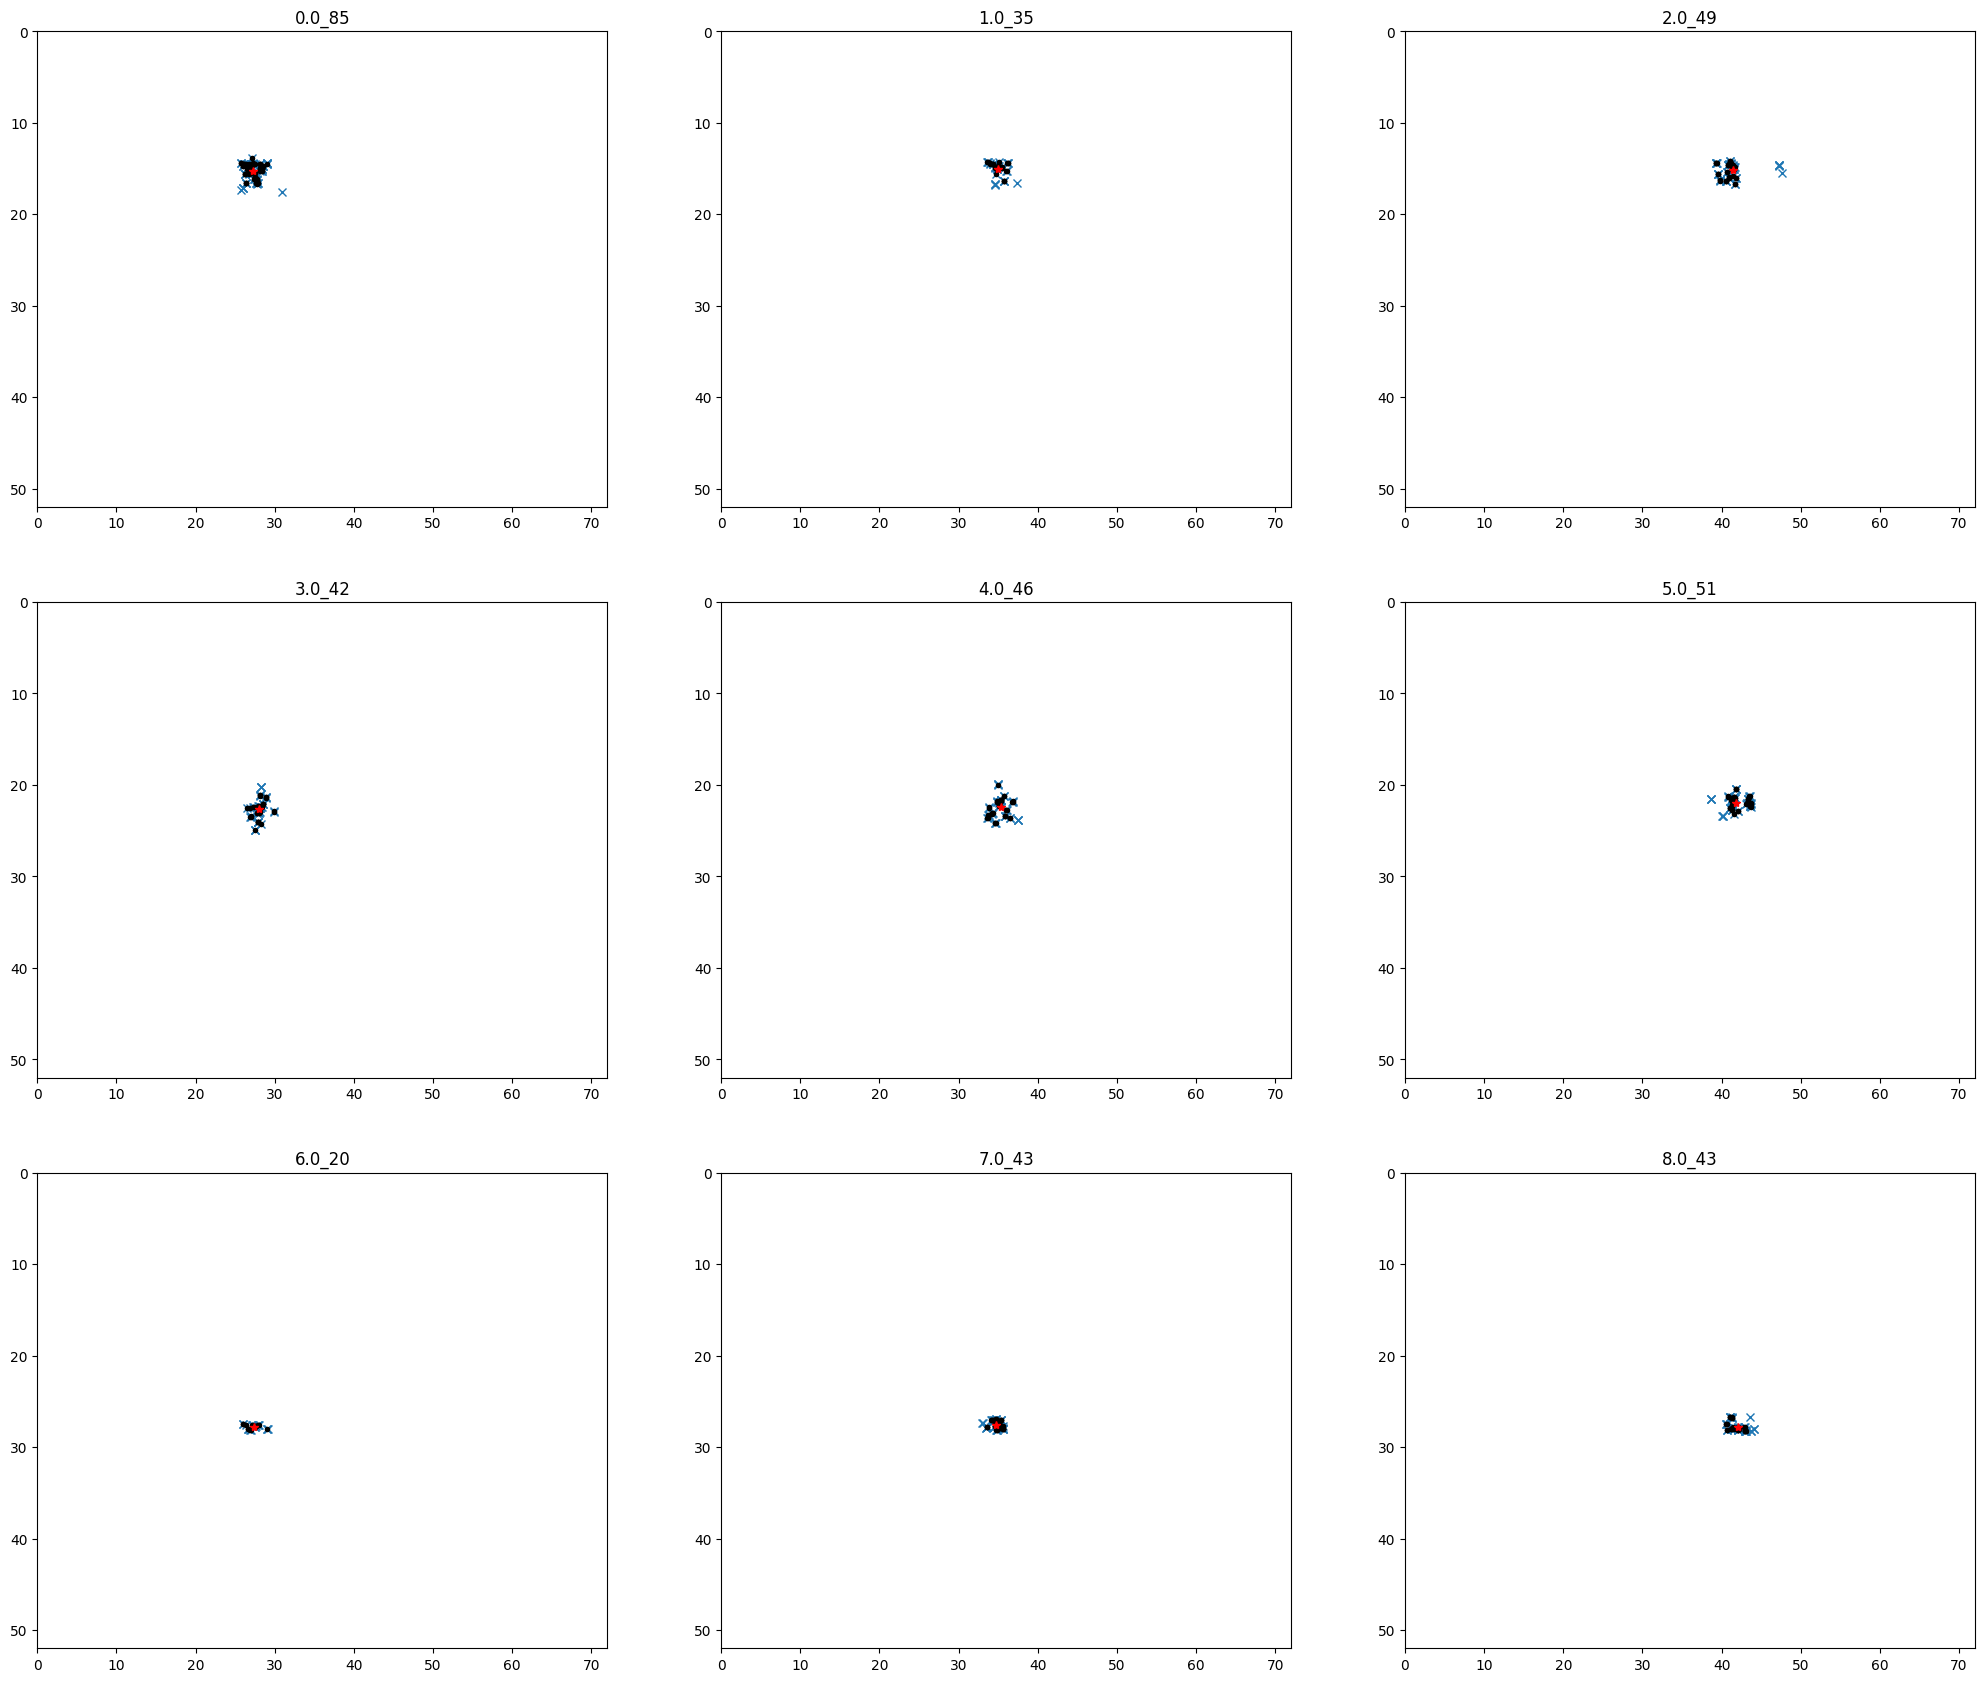

In [152]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df['cluster_label'].unique()):
    x=df.loc[df['cluster_label']==cluster_name].reset_index()
    plt.subplot(3,3,int(cluster_name)+1)
    plt.gca().set_title(str(cluster_name)+'_' + str(len(x)))
    cluster_center = np.column_stack((x['mean_gt_obstacle_cen_x_cm'].unique(),x['mean_gt_obstacle_cen_y_cm'].unique()))
    cluster = np.column_stack((x['gt_obstacle_cen_x_cm'].to_numpy(),x['gt_obstacle_cen_y_cm'].to_numpy()))
    distances = cdist(cluster_center,cluster)
    plt.plot(x['gt_obstacle_cen_x_cm'],x['gt_obstacle_cen_y_cm'],'x')
    plt.plot(x['gt_obstacle_cen_x_cm'].iloc[np.where(distances<np.percentile(distances,90))[1]],x['gt_obstacle_cen_y_cm'].iloc[np.where(distances<np.percentile(distances,90))[1]],'.',color='black')
    plt.plot(x['mean_gt_obstacle_cen_x_cm'].unique(),x['mean_gt_obstacle_cen_y_cm'].unique(),'*',color = 'red')
    plt.ylim([52,0]); plt.xlim([0, 72])

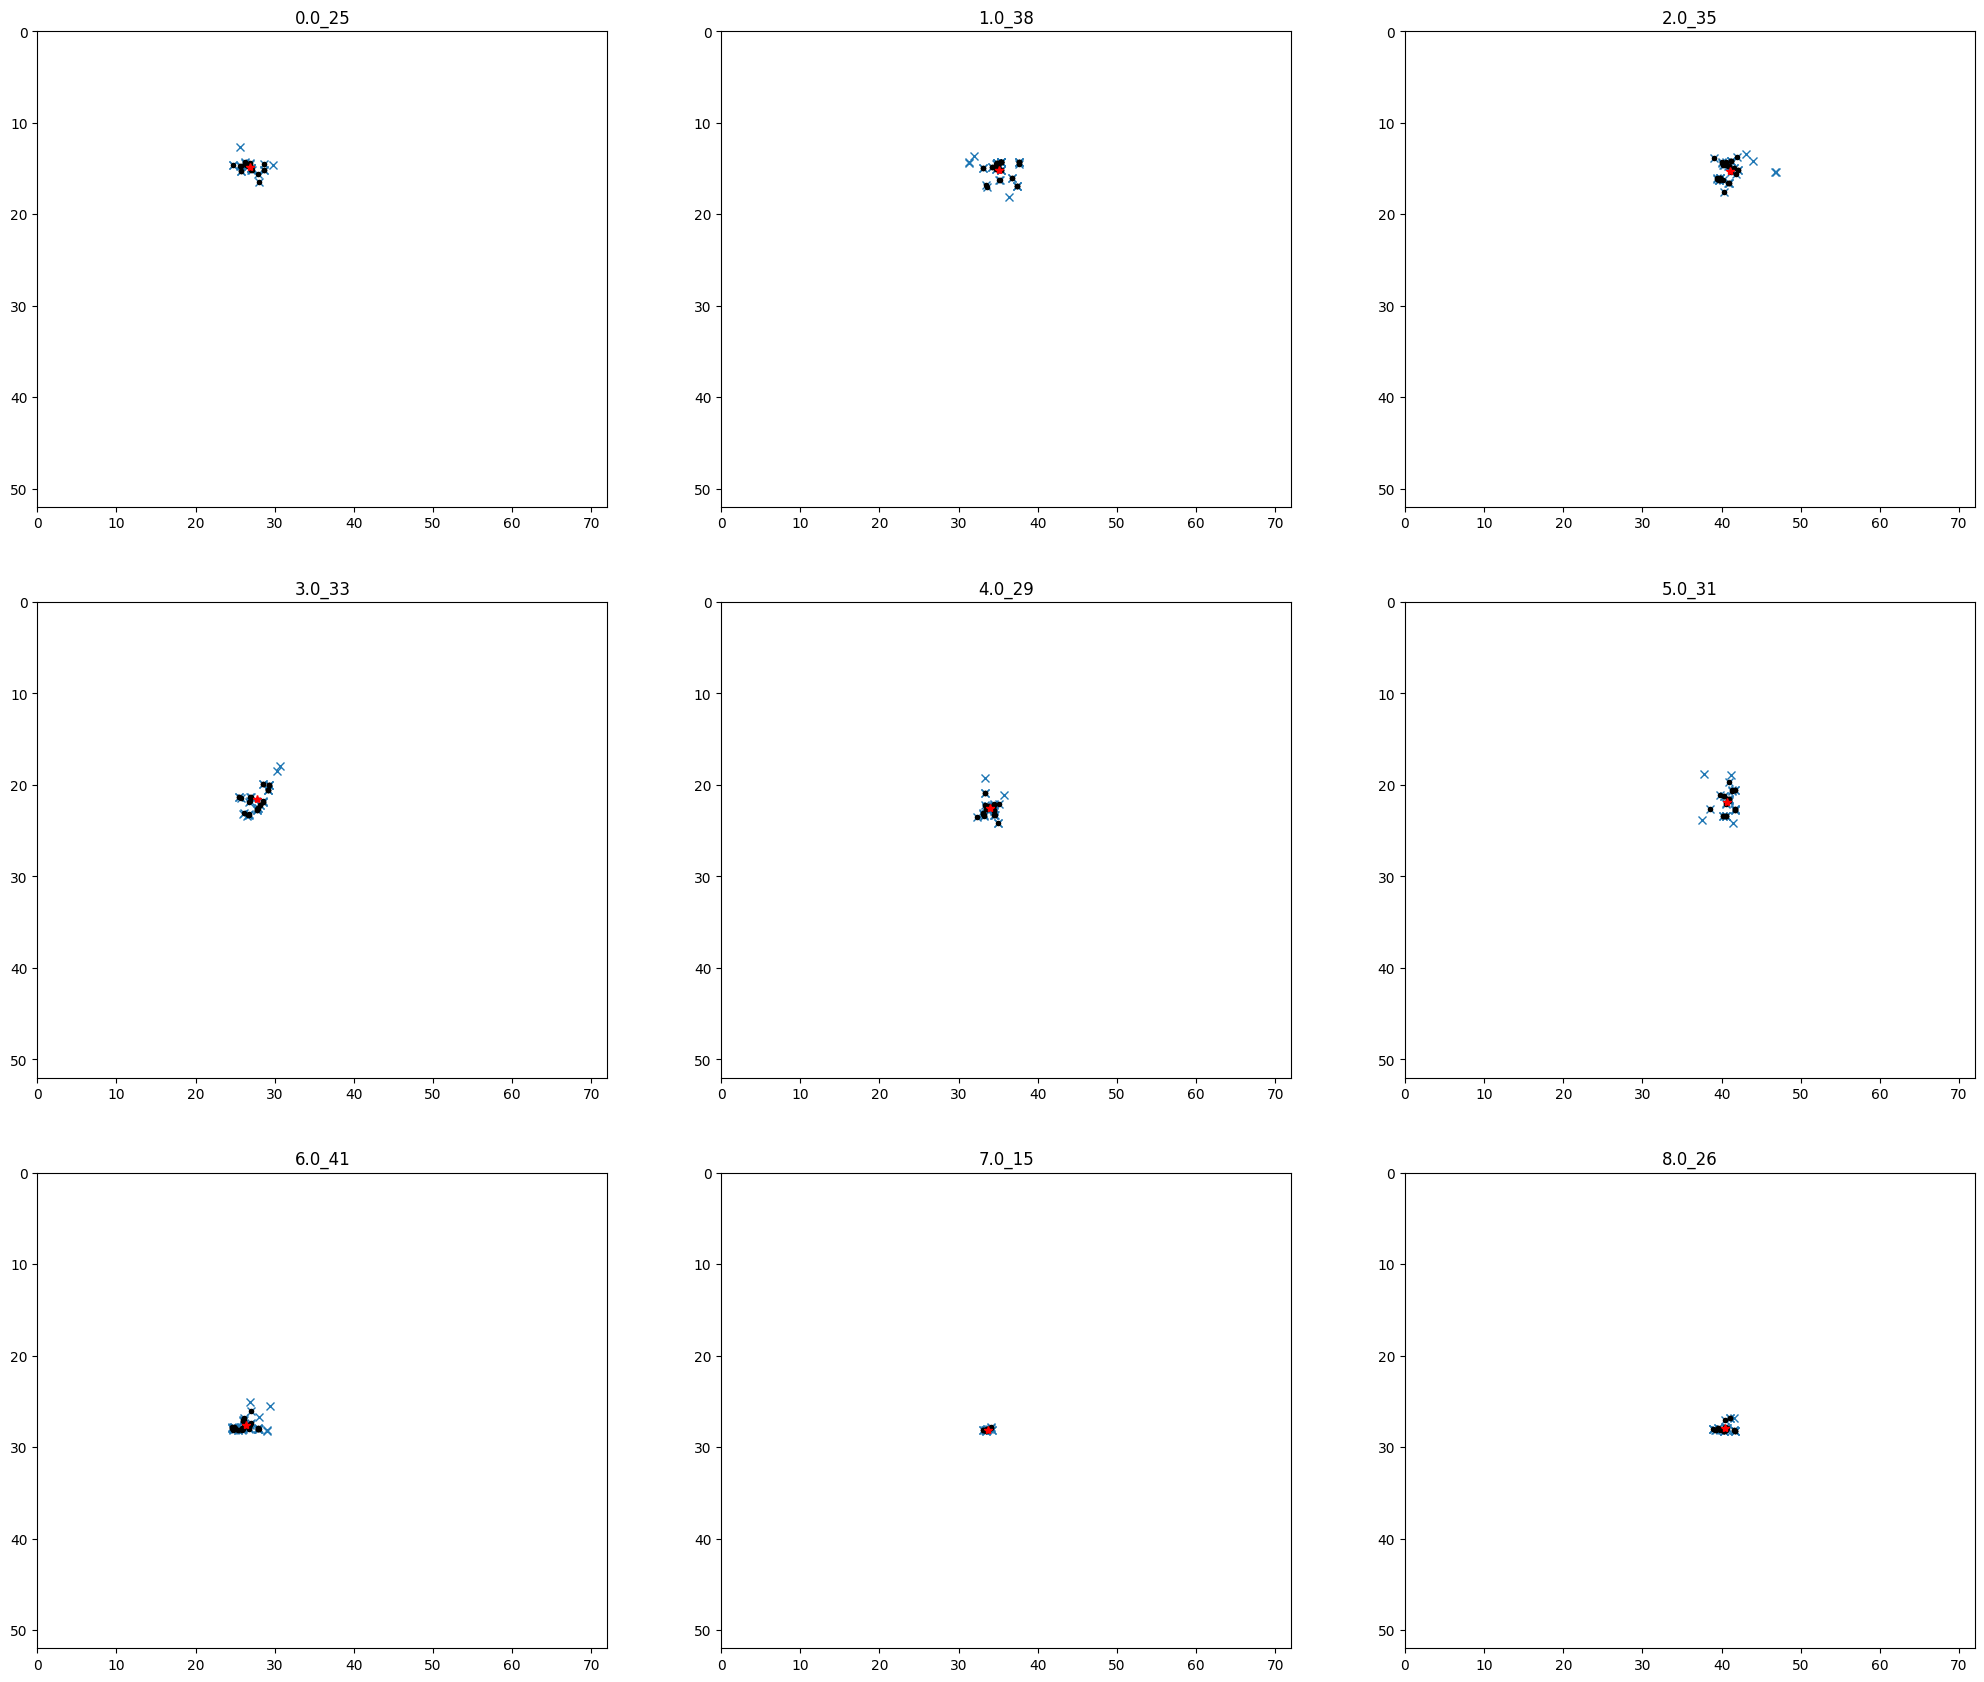

In [153]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df_dark['cluster_label'].unique()):
    x=df_dark.loc[df_dark['cluster_label']==cluster_name].reset_index()
    plt.subplot(3,3,int(cluster_name)+1)
    plt.gca().set_title(str(cluster_name)+'_' + str(len(x)))
    cluster_center = np.column_stack((x['mean_gt_obstacle_cen_x_cm'].unique(),x['mean_gt_obstacle_cen_y_cm'].unique()))
    cluster = np.column_stack((x['gt_obstacle_cen_x_cm'].to_numpy(),x['gt_obstacle_cen_y_cm'].to_numpy()))
    distances = cdist(cluster_center,cluster)
    plt.plot(x['gt_obstacle_cen_x_cm'],x['gt_obstacle_cen_y_cm'],'x')
    plt.plot(x['gt_obstacle_cen_x_cm'].iloc[np.where(distances<np.percentile(distances,90))[1]],x['gt_obstacle_cen_y_cm'].iloc[np.where(distances<np.percentile(distances,90))[1]],'.',color='black')
    plt.plot(x['mean_gt_obstacle_cen_x_cm'].unique(),x['mean_gt_obstacle_cen_y_cm'].unique(),'*',color = 'red')
    plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
np.where(distances<np.percentile(distances,90))

In [ ]:
for clusters, cluster_name in enumerate(df['cluster_label'].unique()):
    x=df.loc[df['cluster_label']==cluster_name]
    cluster_center = np.column_stack((x['mean_gt_obstacle_cen_x_cm'].unique(),x['mean_gt_obstacle_cen_y_cm'].unique()))
    cluster = np.column_stack((x['gt_obstacle_cen_x_cm'].to_numpy(),x['gt_obstacle_cen_y_cm'].to_numpy()))
    distances = cdist(cluster_center,cluster)
    df.loc[df['cluster_label']==cluster_name] = df.loc[df['cluster_label']==cluster_name].iloc[np.where(distances<np.percentile(distances,90))[1]],x['gt_obstacle_cen_y_cm'].iloc[np.where(distances<np.percentile(distances,90))[1]]


In [ ]:
 df.loc[df['cluster_label']==cluster_name].iloc[np.where(distances<np.percentile(distances,90))[1]],x['gt_obstacle_cen_y_cm'].iloc[np.where(distances<np.percentile(distances,90))[1]]


In [ ]:
gt_label = df['cluster_label'].astype(int)
gt_label = gt_label.tolist()
#create obstacle_xypos array 
obstacle_xpos = np.array(df.loc[:,'gt_obstacle_cen_x_cm'])
obstacle_ypos = np.array(df.loc[:,'gt_obstacle_cen_y_cm'])
obstacle_xypos_ar = np.stack((obstacle_xpos.astype(int), obstacle_ypos.astype(int)))
plt.figure()
for i in range(len(df['cluster_label'])):
    obstacle_xypos = obstacle_xypos_ar[:,i] 
    plt.plot(obstacle_xypos[0].astype(int), obstacle_xypos[1].astype(int), '*', color=list(mcolors.TABLEAU_COLORS)[gt_label[i]])
    plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
gt_label = df_dark['cluster_label'].astype(int)
gt_label = gt_label.tolist()
#create obstacle_xypos array 
obstacle_xpos = np.array(df_dark.loc[:,'gt_obstacle_cen_x_cm'])
obstacle_ypos = np.array(df_dark.loc[:,'gt_obstacle_cen_y_cm'])
obstacle_xypos_ar = np.stack((obstacle_xpos.astype(int), obstacle_ypos.astype(int)))
plt.figure()
for i in range(len(df_dark['cluster_label'])):
    obstacle_xypos = obstacle_xypos_ar[:,i] 
    plt.plot(obstacle_xypos[0].astype(int), obstacle_xypos[1].astype(int), '*', color=list(mcolors.TABLEAU_COLORS)[gt_label[i]])
    plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
x = np.concatenate(array)
sum(np.isnan(x.astype('float')))

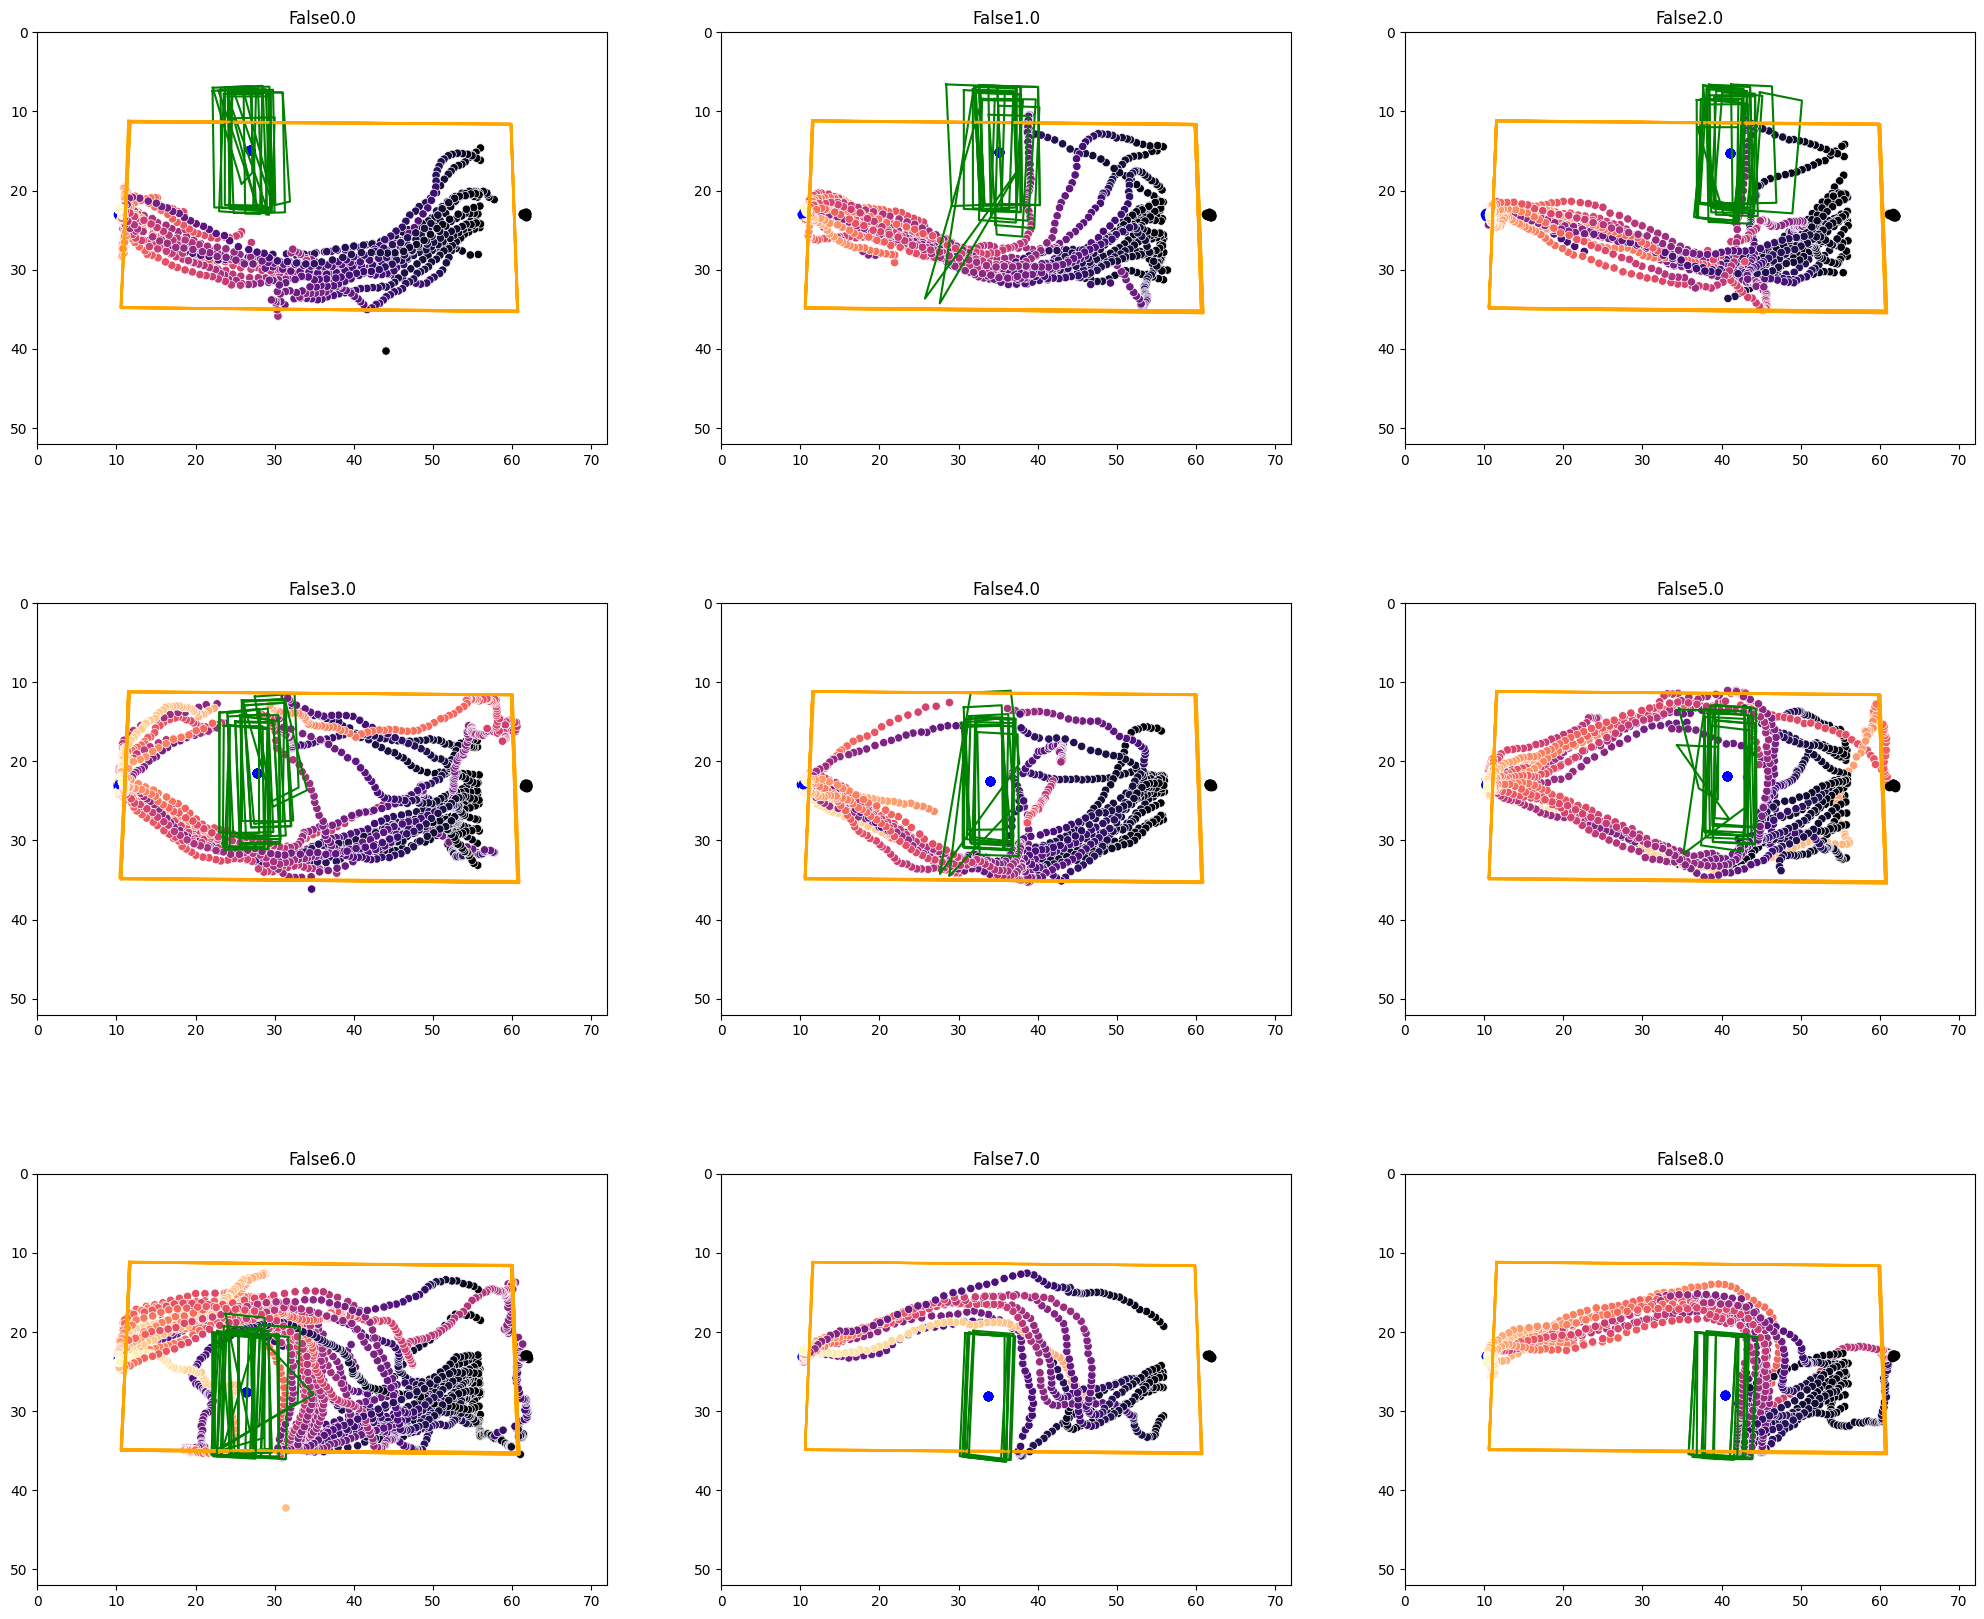

In [157]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df_dark['cluster_label'].unique()):
    x=df_dark.loc[df_dark['cluster_label']==cluster_name]
    for i, row in x.iterrows():
        if row['odd'] == False:
            plt.subplot(3,3,int(cluster_name)+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(row['cluster_label']))
    
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')


            plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    
   
    
    
            plt.scatter(row['mean_gt_obstacle_cen_x_cm'],row['mean_gt_obstacle_cen_y_cm'],color='blue')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
            #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
            plt.ylim([52,0]); plt.xlim([0, 72])

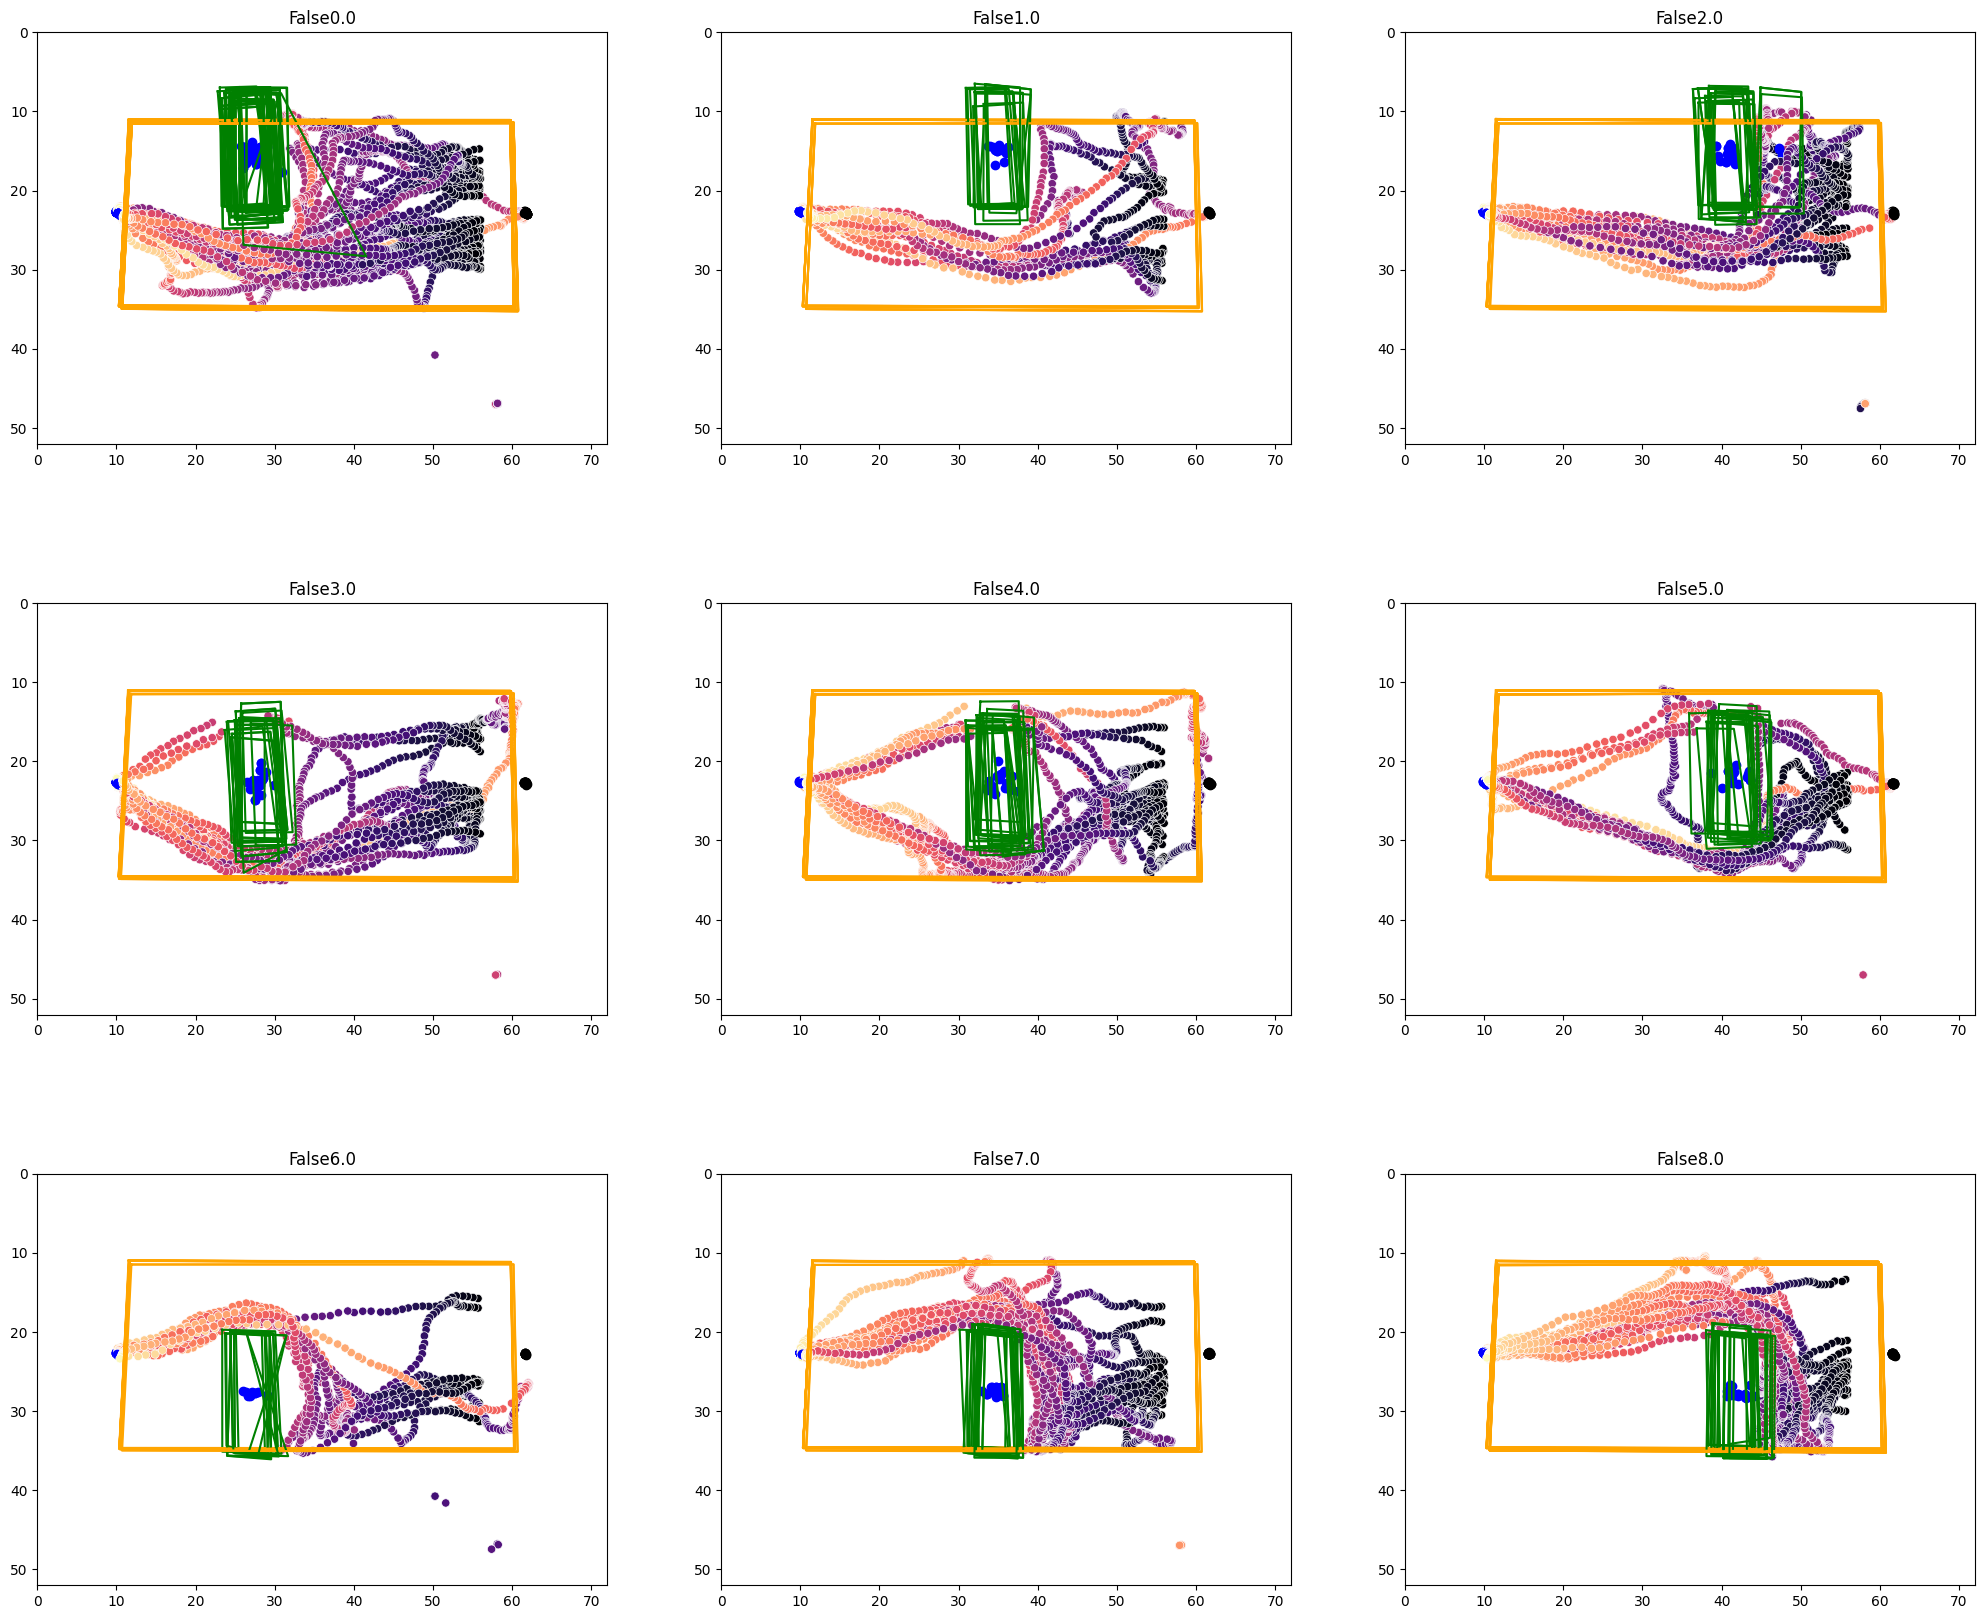

In [158]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df['cluster_label'].unique()):
    x=df.loc[df['cluster_label']==cluster_name]
    for i, row in x.iterrows():
        if row['odd'] == False:
            plt.subplot(3,3,int(cluster_name)+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(row['cluster_label']))
    
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')


            plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    
   
    
    
            plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
            #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
            plt.ylim([52,0]); plt.xlim([0, 72])

In [ ]:
test = df[df['odd']==True]
test = test.sample(30)
test = test.reset_index()

y = nearestX_roundup(len(test),4)
fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(test)),dpi = 100)
for ind,row in test.iterrows():
    plt.subplot(int((y/4)),4,ind+1)
    plt.gca().set_title(str(row['facing_angle']))
    for indx,i in enumerate(row['head_angle']):
                    current_ang = i
                    x1 = row['ts_nose_x_cm'][indx]
                    y1 = row['ts_nose_y_cm'][indx]
                    x2 = x1-3 * np.cos(current_ang)
                    y2 = y1-3* np.sin(current_ang)
                    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
    for indx,i in enumerate(row['body_angle']):
            current_ang = i
            x1 = row['ts_midspine_x_cm'][indx]
            y1 = row['ts_midspine_y_cm'][indx]
            x2 = x1-3 * np.cos(current_ang)
            y2 = y1-3* np.sin(current_ang)
            plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')
    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
            [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    sns.scatterplot(x=row['obstacle_intersect_nose_x'],y=row['obstacle_intersect_nose_y'],hue = enumerate(row['obstacle_intersect_nose_x']), palette ='magma',legend=False)    
    plt.scatter(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],color = 'blue')
    plt.scatter(row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'],color = 'red')
    plt.scatter(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'],color = 'orange')
    plt.scatter(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'],color = 'green')
    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
    plt.scatter(row['ts_nose_x_cm'],row['ts_nose_y_cm'], color = 'c',s=1)
    plt.scatter(row['ts_spine_x_cm'],row['ts_spine_y_cm'], color = 'm',s=1)
    plt.ylim([52,0]); plt.xlim([0, 72])

In [147]:
df['date']

0      021423
1      021423
2      021423
3      021423
4      021423
        ...  
425    021723
426    021723
427    021723
428    021723
429    021723
Name: date, Length: 414, dtype: object

In [ ]:
df.loc[range(10)]

In [148]:
df1 = df.loc[df['date']=='021423']

In [149]:
df1

first_poke   second_poke  \
0    39753.437504  39759.360614   
1    39759.360614  39765.067315   
2    39765.067315  39769.667340   
3    39769.667340  39773.149132   
4    39773.149132  39777.282432   
..            ...           ...   
111  40385.851635  40389.530252   
112  40420.437222  40424.971660   
113  40588.760230  40594.249113   
114  40612.977779  40619.671116   
115  40664.993177  40670.256883   

                                      trial_timestamps  \
0    [39753.447974, 39753.464972, 39753.481612, 397...   
1    [39759.366771, 39759.383436, 39759.400281, 397...   
2    [39765.069388, 39765.085593, 39765.103078, 397...   
3    [39769.670566, 39769.687168, 39769.703872, 397...   
4    [39773.15566, 39773.171801, 39773.188416, 3977...   
..                                                 ...   
111  [40385.866944, 40385.883788, 40385.900224, 403...   
112  [40420.44526, 40420.462259, 40420.478963, 4042...   
113  [40588.770547, 40588.7872, 40588.803814, 40588...   
114  [40612.97902, 40612.995481, 40613.012006, 4061...   
115  [40664.996979, 40665.013452, 40665.03063, 4066...   

                                       trial_vidframes  \
0    [[4120, 4121, 4122, 4123, 4124, 4125, 4126, 41...   
1    [4475, 4476, 4477, 4478, 4479, 4480, 4481, 448...   
2    [[4817, 4818, 4819, 4820, 4821, 4822, 4823, 48...   
3    [5093, 5094, 5095, 5096, 5097, 5098, 5099, 510...   
4    [[5302, 5303, 5304, 5305, 5306, 5307, 5308, 53...   
..                                                 ...   
111  [42052, 42053, 42054, 42055, 42056, 42057, 420...   
112  [44126, 44127, 44128, 44129, 44130, 44131, 441...   
113  [[54222, 54223, 54224, 54225, 54226, 54227, 54...   
114  [[55674, 55675, 55676, 55677, 55678, 55679, 55...   
115  [[58794, 58795, 58796, 58797, 58798, 58799, 58...   

                                                nose_x  \
0    [685.0384521484375, 685.6655883789062, 685.922...   
1    [117.92620086669922, 118.06155395507812, 117.6...   
2    [685.3831176757812, 685.5314331054688, 685.451...   
3    [118.1801528930664, 116.69680786132812, 115.82...   
4    [685.3495483398438, 686.1343383789062, 686.132...   
..                                                 ...   
111  [118.25326538085938, 118.1613540649414, 117.56...   
112  [114.98355102539062, 114.96160888671875, 115.3...   
113  [687.5767211914062, 688.1234741210938, 688.286...   
114  [690.0828247070312, 690.5658569335938, 690.436...   
115  [692.9182739257812, 692.9780883789062, 693.170...   

                                                nose_y  \
0    [258.2817687988281, 257.7115478515625, 257.263...   
1    [249.9185028076172, 250.79656982421875, 250.89...   
2    [256.2189636230469, 256.02020263671875, 256.25...   
3    [253.0938262939453, 252.00833129882812, 250.46...   
4    [260.4528503417969, 259.99151611328125, 259.72...   
..                                                 ...   
111  [254.9131622314453, 255.1566619873047, 253.979...   
112  [262.1111755371094, 262.07525634765625, 262.40...   
113  [263.2582702636719, 263.1942138671875, 262.618...   
114  [261.7550354003906, 262.2436828613281, 262.214...   
115  [259.6377258300781, 259.5687255859375, 259.580...   

                                       nose_likelihood  \
0    [0.9999439716339111, 0.9998946189880371, 0.999...   
1    [0.999996542930603, 0.9999963045120239, 0.9999...   
2    [0.9998822212219238, 0.9999158382415771, 0.999...   
3    [0.9999984502792358, 0.999997615814209, 0.9999...   
4    [0.999984860420227, 0.9999806880950928, 0.9999...   
..                                                 ...   
111  [0.9999604225158691, 0.9999357461929321, 0.999...   
112  [0.9999171495437622, 0.9999326467514038, 0.999...   
113  [0.9999948740005493, 0.9999933242797852, 0.999...   
114  [0.9999905824661255, 0.9999887943267822, 0.999...   
115  [0.9999833106994629, 0.9999833106994629, 0.999...   

                                             leftear_x  \
0    [662.178955078125, 663.3298950195312, 

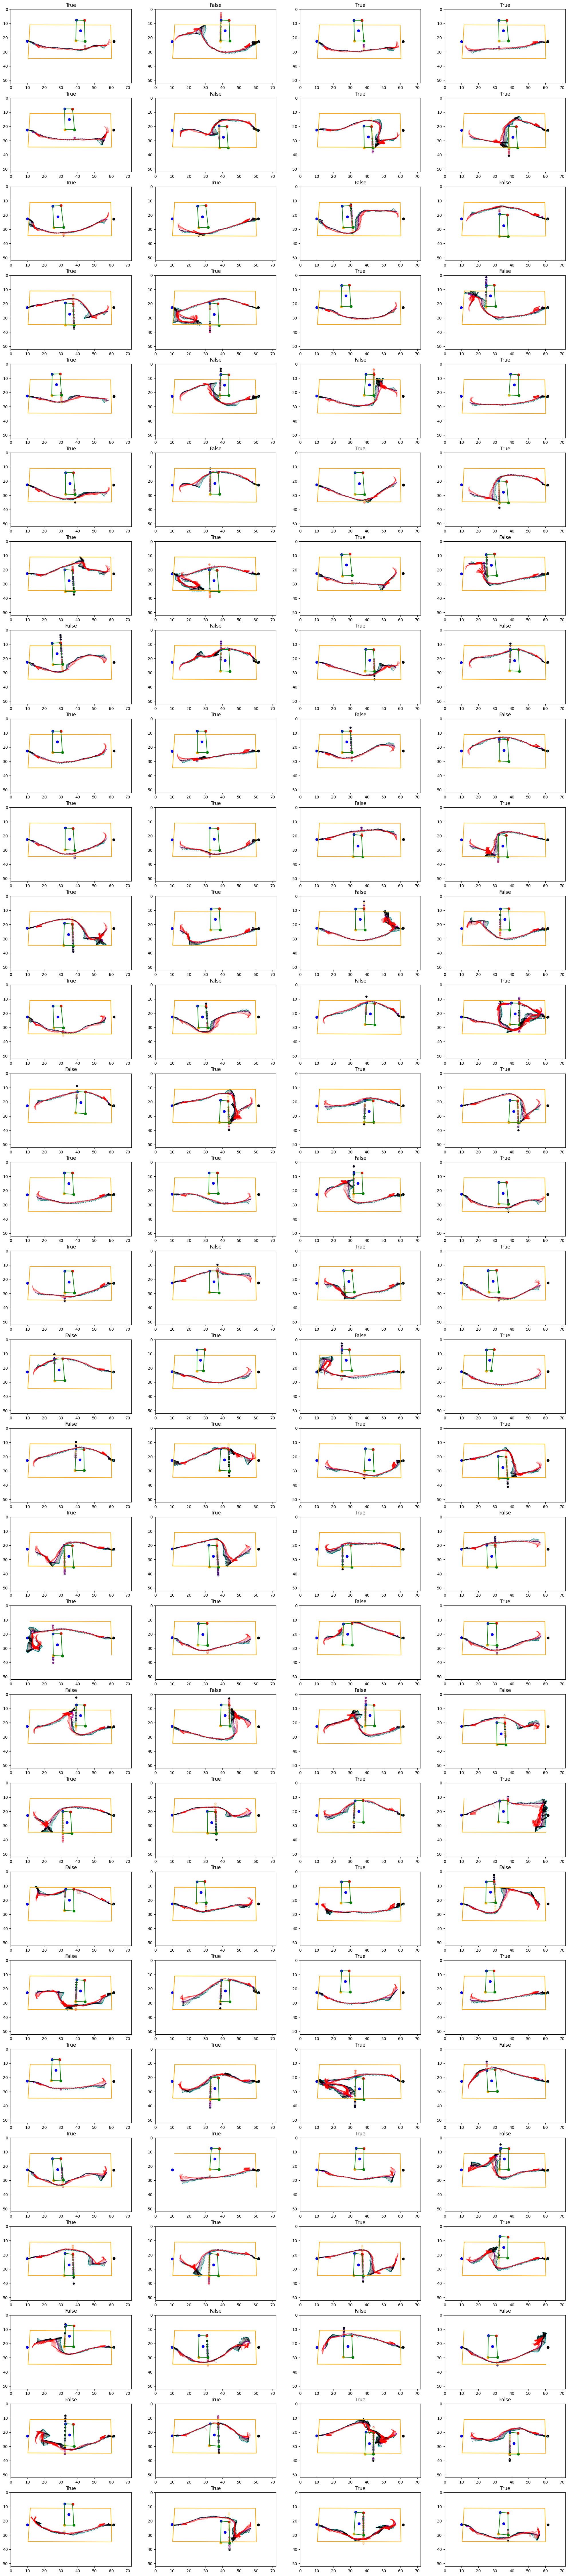

In [150]:
y = nearestX_roundup(len(df1),4)
fig, ax = plt.subplots(int((y/4)),4, figsize=(25,len(df1)),dpi = 100)
for ind,row in df1.iterrows():
    plt.subplot(int((y/4)),4,ind+1)
    plt.gca().set_title(str(row['facing_angle']))
    for indx,i in enumerate(row['head_angle']):
                    current_ang = i
                    x1 = row['ts_nose_x_cm'][indx]
                    y1 = row['ts_nose_y_cm'][indx]
                    x2 = x1-3 * np.cos(current_ang)
                    y2 = y1-3* np.sin(current_ang)
                    plt.plot((x1,x2), (y1,y2), '-',color = 'black',alpha=0.3)
    for indx,i in enumerate(row['body_angle']):
            current_ang = i
            x1 = row['ts_midspine_x_cm'][indx]
            y1 = row['ts_midspine_y_cm'][indx]
            x2 = x1-3 * np.cos(current_ang)
            y2 = y1-3* np.sin(current_ang)
            plt.plot((x1,x2), (y1,y2), '-',color = 'red',alpha=0.3)
    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')
    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
            [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    sns.scatterplot(x=row['obstacle_intersect_nose_x'],y=row['obstacle_intersect_nose_y'],hue = enumerate(row['obstacle_intersect_nose_x']), palette ='magma',legend=False)    
    plt.scatter(row['gt_obstacleTL_x_cm'],row['gt_obstacleTL_y_cm'],color = 'blue')
    plt.scatter(row['gt_obstacleTR_x_cm'],row['gt_obstacleTR_y_cm'],color = 'red')
    plt.scatter(row['gt_obstacleBL_x_cm'],row['gt_obstacleBL_y_cm'],color = 'orange')
    plt.scatter(row['gt_obstacleBR_x_cm'],row['gt_obstacleBR_y_cm'],color = 'green')
    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
    plt.scatter(row['ts_nose_x_cm'],row['ts_nose_y_cm'], color = 'c',s=1)
    plt.scatter(row['ts_spine_x_cm'],row['ts_spine_y_cm'], color = 'm',s=1)
    plt.ylim([52,0]); plt.xlim([0, 72])